In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import models, layers 
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# **Data preprocessing**

**Only Gas price and costs**

In [ ]:
file_path2 = "/kaggle/input/costgas-price/OperationCostsGasPrices (5).xlsx"
data_jan_2018 = pd.read_excel(file_path2)
scaler_y2 = StandardScaler()
scaler_X2 = StandardScaler()
X2 = data_jan_2018.iloc[:,0].values.reshape(-1,1) 
y2 = data_jan_2018.iloc[:,1].values.reshape(-1,1)
X2 = scaler_X2.fit_transform(X2)
y2 = scaler_y2.fit_transform(y2)
X_train2, X_temp2, y_train2, y_temp2 = train_test_split(X2, y2, test_size=0.3, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_temp2, y_temp2, test_size=0.5, random_state=42)

**Month as sin and cos, gas price and costs as target**

In [16]:
file_path = "/kaggle/input/data-month-encoded/gasprice_2_feat_monthly_2019_data_cos_and_sin.xlsx"
data_2019_sincos = pd.read_excel(file_path)
scaler_y = StandardScaler()
scaler_X = StandardScaler()
X = data_2019_sincos.iloc[:,2:5].values
y = data_2019_sincos.iloc[:,5].values.reshape(-1,1)
print(f"Standard deviation in target set is {np.std(y)} and mean is {np.mean(y)}")
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



Standard deviation in target set is 412106.3235621424 and mean is 648313.7862656774


# **Constructing models** 

In [4]:
def create_model_1layer(learning_rate, unit):
    model = models.Sequential()
    model.add(layers.Input(shape=(3,)))
    model.add(layers.Dense(unit,  activation='relu'))
    model.add(layers.Dense(1))
    optimizer = SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    return model
    
def create_model_layer2layers(learning_rate, unit1, unit2):
    model = models.Sequential()
    model.add(layers.Input(shape=(3,)))
    model.add(layers.Dense(unit1, activation='relu'))
    model.add(layers.Dense(unit2, activation='relu'))
    model.add(layers.Dense(1))
    optimizer = SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    return model

def create_model_layer3layers(learning_rate, unit1, unit2, unit3):
    model = models.Sequential()
    model.add(layers.Input(shape=(3,)))
    model.add(layers.Dense(unit1, activation='relu'))
    model.add(layers.Dense(unit2, activation='relu'))
    model.add(layers.Dense(unit3, activation='relu'))
    model.add(layers.Dense(1))
    optimizer = SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    return model
def create_model_layer4layers(learning_rate, unit1, unit2, unit3, unit4):
    model = models.Sequential()
    model.add(layers.Input(shape=(3,)))
    model.add(layers.Dense(unit1, activation='relu'))
    model.add(layers.Dense(unit2, activation='relu'))
    model.add(layers.Dense(unit3, activation='relu'))
    model.add(layers.Dense(unit4, activation='relu'))
    model.add(layers.Dense(1))
    optimizer = SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    return model

#  **Evaluate Models**

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


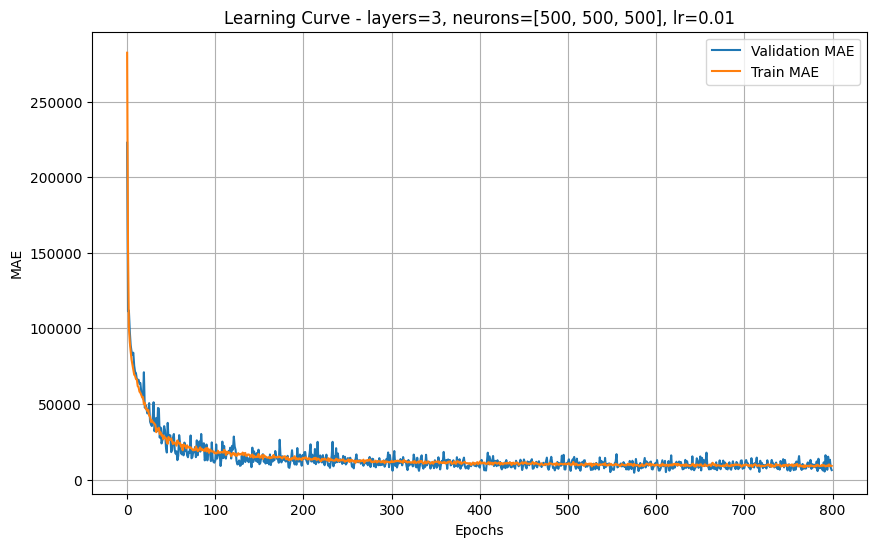


Config: layers=3_neurons=[500, 500, 500]_lr=0.01
Final Val MAE: 6237.6420, Final train MAE: 4586.6087
{'layers=3_neurons=[500, 500, 500]_lr=0.01': {'final_train_mae': 4586.608696869306, 'final_val_mae': 6237.641985836495}}


In [6]:
#inputs = neurons per layer is lijst van lijsten [[100], [100,200],[300,300,300]]
def tune_hyperparameters(learning_rates, neurons_per_layer_options,X_train, y_train, X_val, y_val,scaler_y,
                         epochs = 800, batch_size=4):
    results = {}
    tf.random.set_seed(42)
    for lr in learning_rates:
        for neurons_per_layer in neurons_per_layer_options:
            # 1. Build and compile the model
            num_layers = len(neurons_per_layer)
            if num_layers == 1:
                model = create_model_1layer(learning_rate=lr, 
                                            unit=neurons_per_layer[0])
            elif num_layers == 2:
                model = create_model_layer2layers(learning_rate=lr, 
                                             unit1=neurons_per_layer[0], 
                                             unit2=neurons_per_layer[1])
            elif num_layers == 3:
                model = create_model_layer3layers(learning_rate=lr, 
                                             unit1=neurons_per_layer[0], 
                                             unit2=neurons_per_layer[1], 
                                             unit3=neurons_per_layer[2])
            elif num_layers == 4:
                model = create_model_layer4layers(learning_rate=lr, 
                                             unit1=neurons_per_layer[0], 
                                             unit2=neurons_per_layer[1], 
                                             unit3=neurons_per_layer[2],
                                             unit4=neurons_per_layer[3])
            
            # 2. Train (fit) the model
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size,verbose=0)
            
            pred_scaled = model.predict(X_train)
            pred = scaler_y.inverse_transform(pred_scaled)
            y_train_origin = scaler_y.inverse_transform(y_train)
            train_mae = abs(y_train_origin-pred).mean()
            # 3. Evaluate the model on the validation set to get final performance
            val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
            val_mae_origin = val_mae*scaler_y.scale_[0]

            #Make sure it plots actual values and not scaled
            scale_factor = scaler_y.scale_[0]            
            train_mae_scaled = [mae * scale_factor for mae in history.history['mae']]
            val_mae_scaled = [mae * scale_factor for mae in history.history['val_mae']]

            #plot
            plt.figure(figsize=(10, 6))
            plt.plot(val_mae_scaled, label='Validation MAE')
            plt.plot(train_mae_scaled, label='Train MAE')
            plt.title(f"Learning Curve - layers={num_layers}, neurons={neurons_per_layer}, lr={lr}")
            plt.xlabel("Epochs")
            plt.ylabel("MAE")
            plt.legend()
            plt.grid()
            plt.savefig(f"Learning curve_layers={num_layers}_neurons={neurons_per_layer}_lr={lr}.png", format = 'png', dpi = 300)
            plt.show()
            # 5. Store results for this configuration
            config_name = f"layers={num_layers}_neurons={neurons_per_layer}_lr={lr}"
            results[config_name] = {
                "final_train_mae" : train_mae,
                "final_val_mae": val_mae_origin
            }
            # 6.quick summary
            print(f"\nConfig: {config_name}")
            print(f"Final Val MAE: {val_mae_origin:.4f}, Final train MAE: {train_mae:.4f}")
    return results

results = tune_hyperparameters([0.01], [[500,500,500]], 
                              X_train, y_train, X_val, y_val, scaler_y)
print(results)

# **Best models**

In [ ]:
#Best models are 100x3, 50x3 and 300x3 after 800/1000 epochs
tf.random.set_seed(42)
best_model1 = create_model_layer3layers(0.01,100,100,100)
best_model1.fit(X_train4, y_train4, validation_data=(X_val4, y_val4),epochs=1000, batch_size=4,verbose=0)



In [7]:
tf.random.set_seed(42)
best_model3 = create_model_layer3layers(0.01, 500, 500, 500)
best_model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 1000, batch_size=4, verbose=0)

In [8]:
tf.random.set_seed(42)
best_model2 = create_model_layer2layers(0.01, 300, 300, 300)
best_model2.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs = 400, batch_size=4, verbose=0)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# **Visualizing results**

**Prediction vs real points and AE vs Months and gas prices**

In [8]:
#weighted Mae:
def weighted_mae(model, X_test, y_test, scaler_y, scaler_X):
    y_predict = scaler_y.inverse_transform(model.predict(X_test))
    y_test_origin = scaler_y.inverse_transform(y_test)
    normal_mae = abs(y_test_origin-y_predict).mean()
    X_test_origin = scaler_X.inverse_transform(X_test)
    sin_month = X_test_origin[:,1]
    cos_month = X_test_origin[:,2]
    months = np.round((np.arctan2(sin_month, cos_month) / (2 * np.pi)) * 12 + 1) % 12 + 1
    month_weights = {
        1: 2,   
        2: 1.8,  
        3: 1.6, 
        4: 1.4, 
        5: 1.2, 
        6: 1.0, 
        7: 1.0, 
        8: 1.2, 
        9: 1.4, 
        10: 1.6, 
        11: 1.8,  
        12: 2 }
    weighted_mae = 0
    total_weight = 0
    for i in range(len(y_test_origin)):
        month = int(months[i])  # Convert to integer month
        weight = month_weights[month]
        error = abs(y_test_origin[i] - y_predict[i])
        weighted_mae += weight * error
        total_weight += weight

    weighted_mae /= total_weight  # Normalize by total weight
     

    return f"Normal MAE: {normal_mae}, Weighted MAE: {weighted_mae}"
weighted_mae(best_model3, X_test, y_test, scaler_y, scaler_X)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


'Normal MAE: 6224.435367150516, Weighted MAE: [5939.38284688]'

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6224.435367150516


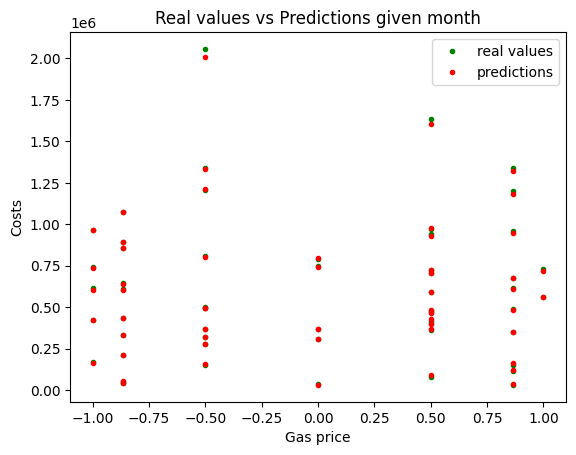

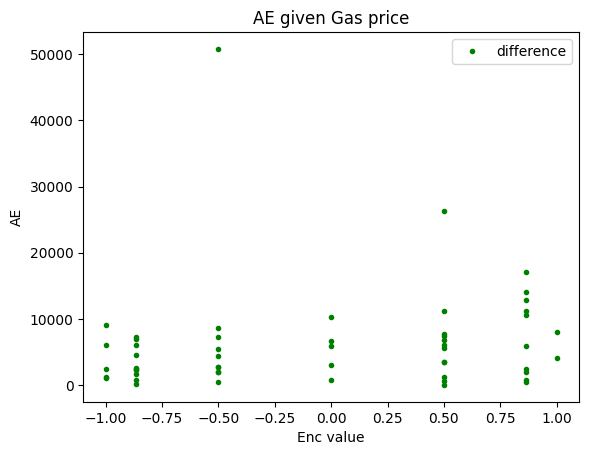

In [18]:
def plot_results(model, X_test, y_test, scaler_X, scaler_y):
    
    y_predict = scaler_y.inverse_transform(model.predict(X_test))
    y_test_origin = scaler_y.inverse_transform(y_test)
    X_test_origin = scaler_X.inverse_transform(X_test)
    test_mae = abs(y_test_origin-y_predict).mean()
    print(test_mae)

    
    plt.figure()
    plt.title("Real values vs Predictions given month")
    plt.plot(X_test_origin[:,0], y_test_origin, 'g.', label = 'real values')
    plt.plot(X_test_origin[:,0], y_predict, 'r.', label = 'predictions')
    plt.xlabel('Gas price')
    plt.ylabel('Costs')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.title("AE given Gas price")
    plt.plot(X_test_origin[:,0], abs(y_test_origin-y_predict), 'g.', label = 'difference')
    plt.xlabel('Enc value')
    plt.ylabel('AE')
    plt.legend()
    plt.show()

plot_results(best_model3, X_test, y_test, scaler_X, scaler_y)



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


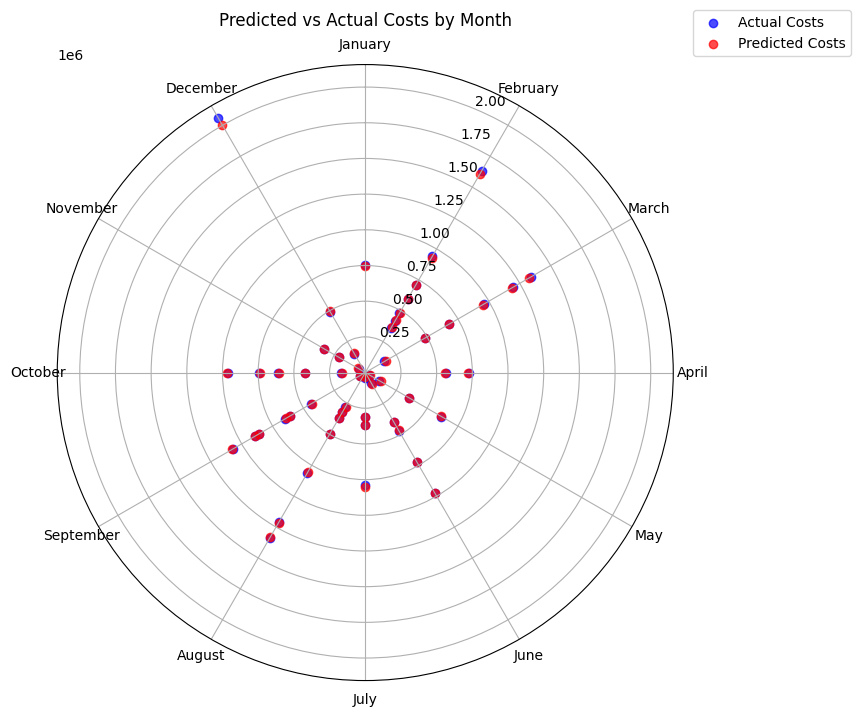

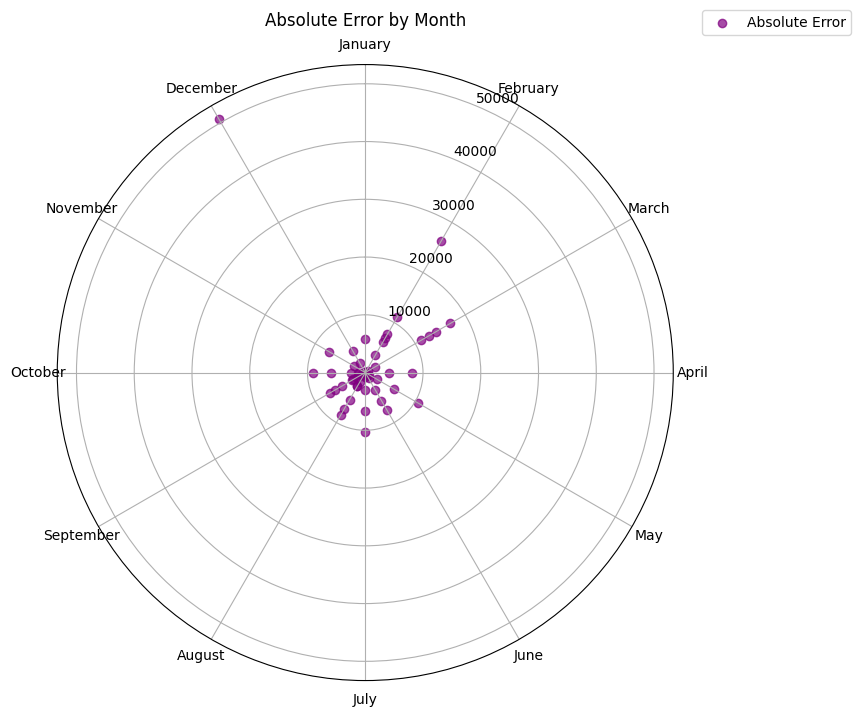

In [21]:
def results_polar_plot(model, X_test, y_test, scaler_X, scaler_y):
    # Unscale data
    X_test_unscaled = scaler_X.inverse_transform(X_test)
    y_test_unscaled = scaler_y.inverse_transform(y_test)
    month_cos = X_test_unscaled[:, 1]
    month_sin = X_test_unscaled[:, 0]
    
    gas_prices = X_test_unscaled[:, 2]
    real_costs = y_test_unscaled.flatten()  # Flatten for plotting
    predicted_costs = scaler_y.inverse_transform(model.predict(X_test)).flatten()  # Flatten predictions
    
    theta = np.arctan2(month_sin, month_cos)  # Calculate the angle in radians
    theta[theta < 0] += 2 * np.pi  # Ensure theta is in [0, 2π]
    absolute_error = np.abs(real_costs - predicted_costs)
    months = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']
    
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
    ax.scatter(theta, real_costs, c='blue', label='Actual Costs', alpha=0.7)
    ax.scatter(theta, predicted_costs, c='red', label='Predicted Costs', alpha=0.7)
    ax.set_theta_offset(np.pi / 2)  
    ax.set_theta_direction(-1)  
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(months)
    ax.set_title('Predicted vs Actual Costs by Month', va='bottom')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.savefig("RealvPredict_MonthvCost.png", format = 'png', dpi=300)
    plt.show()
    
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
    ax.scatter(theta, absolute_error, c='purple', label='Absolute Error', alpha=0.7)
    ax.set_theta_offset(np.pi / 2)  # Rotate so January is at the top
    ax.set_theta_direction(-1)  # Clockwise direction
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(months)
    ax.set_title('Absolute Error by Month', va='bottom')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.savefig("AE_month.png", format = 'png', dpi=300)
    plt.show()
results_polar_plot(best_model3, X_test, y_test, scaler_X, scaler_y)

**3D results**

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
def results_3D(model):
    X_test3_unscaled = scaler_X3.inverse_transform(X_test3)
    y_test3_unscaled = scaler_y3.inverse_transform(y_test3)
    month_cos = X_test3_unscaled[:,1]
    month_sin = X_test3_unscaled[:,0]
    
    gas_prices = X_test3_unscaled[:,2]
    real_costs = y_test3_unscaled
    predicted_costs = scaler_y3.inverse_transform(model.predict(X_test3))
    
    # Step 1: Reconstruct the month from x and y
    theta = np.arctan2(month_cos, month_sin)  # Calculate the angle in radians
    theta[theta < 0] += 2 * np.pi  # Ensure theta is in [0, 2π]
    
    # Convert theta back to months (1-12)
    months = (theta * 12 / (2 * np.pi)).astype(int) + 1
    
    
    r = gas_prices 
    z_real = real_costs  
    z_predicted = predicted_costs 
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    # Real values
    sc_real = ax.scatter(r, theta, z_real, c='blue', label='Real Costs', alpha=0.7)
    # Predicted values
    sc_predicted = ax.scatter(r, theta, z_predicted, c='red', label='Predicted Costs', alpha=0.7)
    
    # Add labels
    ax.set_xlabel('Gas Price (r)')
    ax.set_ylabel('Month (theta)')
    ax.set_zlabel('Cost (z)')
    ax.set_title('Cylindrical Visualization of Costs (Real vs Predicted)')
    ax.legend()
    
    # Adjust theta ticks to show months
    ax.set_yticks(np.linspace(0, 2 * np.pi, 12))
    ax.set_yticklabels([f'Month {i}' for i in range(1, 13)])
    ax.view_init(elev=60, azim=270)
    plt.show()
results_3D(best_model1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


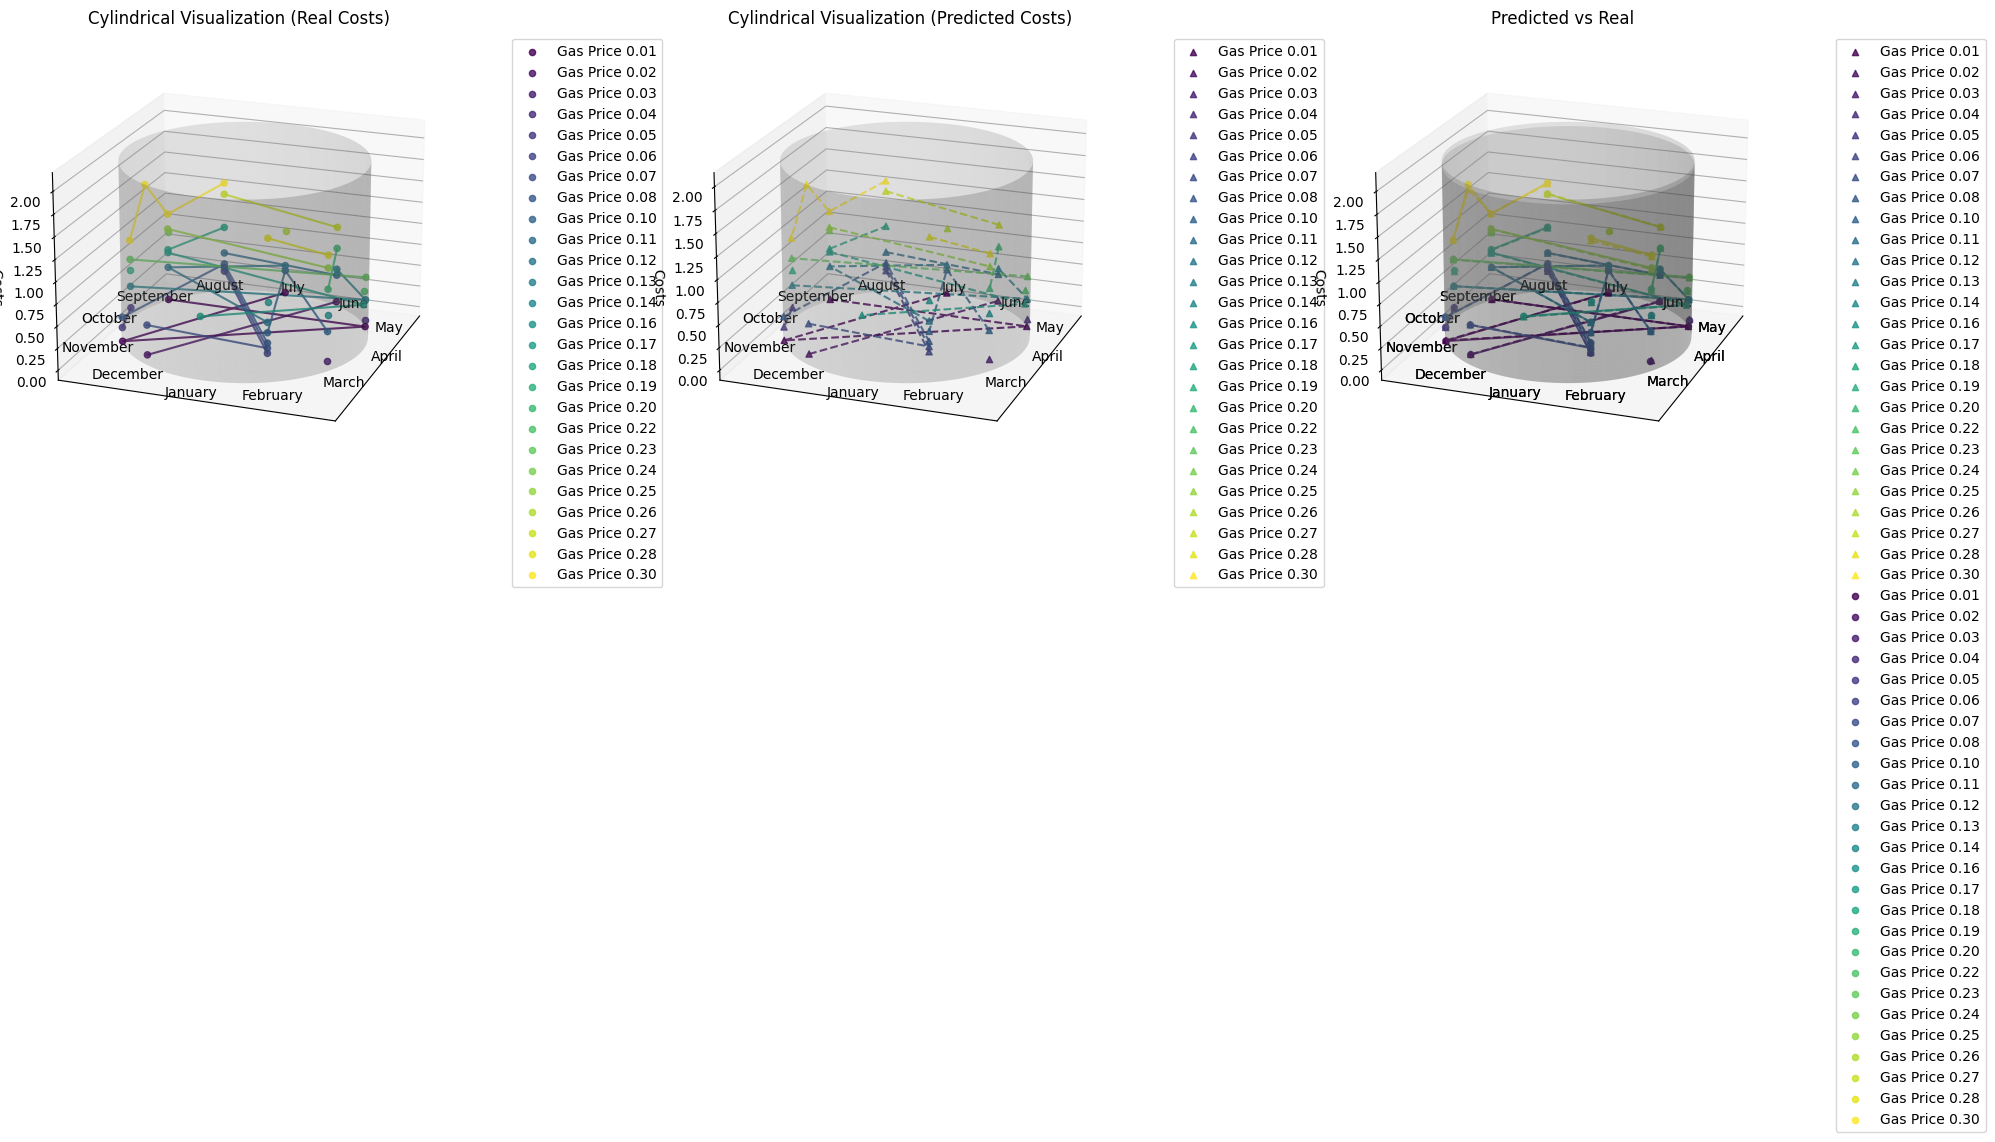

In [22]:
#cilinder

def cilinder(model):
    # X_test3_unscaled etc. aanmaken
    X_test_unscaled = scaler_X.inverse_transform(X_test)
    y_test_unscaled = scaler_y.inverse_transform(y_test)
    month_cos = X_test_unscaled[:, 1]
    month_sin = X_test_unscaled[:, 0]

    gas_prices = X_test_unscaled[:, 2]
    real_costs = y_test_unscaled.flatten()
    predicted_costs = scaler_y.inverse_transform(model.predict(X_test)).flatten()

    # Prepare unique gas prices and group costs by gas price
    unique_gas_prices = np.unique(gas_prices)
    gas_price_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_gas_prices)))
    months = np.linspace(0, 2 * np.pi, 12, endpoint=False)
    month_labels = [
        'January', 'February', 'March', 'April', 'May', 'June', 
        'July', 'August', 'September', 'October', 'November', 'December'
    ]

    # Helperfunctie voor het plotten
    def plot_costs(ax, costs, title, color, linestyle, marker):
        for idx, gas_price in enumerate(unique_gas_prices):
            # Filter punten voor deze gas price
            indices = np.where(gas_prices == gas_price)[0]
            x = month_cos[indices]
            y = month_sin[indices]
            z = costs[indices]
            local_color = gas_price_colors[idx]

            ax.scatter(x, y, z, color=local_color, marker=marker, 
                       label=f'Gas Price {gas_price:.2f}', alpha=0.8)
            ax.plot(x, y, z, linestyle=linestyle, color=local_color, alpha=0.8)

        # Semi-transparante cilinder
        theta_cylinder = np.linspace(0, 2 * np.pi, 100)
        z_cylinder = np.linspace(min(costs), max(costs), 50)
        theta_cylinder, z_cylinder = np.meshgrid(theta_cylinder, z_cylinder)
        x_cylinder = np.cos(theta_cylinder)
        y_cylinder = np.sin(theta_cylinder)
        ax.plot_surface(x_cylinder, y_cylinder, z_cylinder, 
                        alpha=0.2, color='gray', edgecolor='none')

        # Maandlabels op de "cirkel"
        for i, month_label in enumerate(month_labels):
            x_label = 1.2 * np.cos(months[i])  # iets naar buiten voor zichtbaarheid
            y_label = 1.2 * np.sin(months[i])
            ax.text(x_label, y_label, 0, month_label, ha='center', va='center', fontsize=10)

        # As-ticks en labels verbergen
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('Costs')
        ax.set_title(title)
        
        # Eventueel de kijkhoek instellen
        ax.view_init(elev=20, azim=20)

        # Legend buiten het plot plaatsen
        ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

    # Maak de twee figuren aan
    fig = plt.figure(figsize=(20, 20))

    # Subplot 1: Real costs
    ax1 = fig.add_subplot(131, projection='3d')
    plot_costs(ax1, real_costs, 
               'Cylindrical Visualization (Real Costs)',
               color='blue', linestyle='solid', marker='o')

    # Subplot 2: Predicted costs
    ax2 = fig.add_subplot(132, projection='3d')
    plot_costs(ax2, predicted_costs,
               'Cylindrical Visualization (Predicted Costs)',
               color='orange', linestyle='dashed', marker='^')
    #subplot3: both
    ax3 = fig.add_subplot(133, projection='3d')
    plot_costs(ax3, predicted_costs,
               'Predicted vs Real',
               color='orange', linestyle='dashed', marker='^')
    plot_costs(ax3, real_costs, 
               'Predicted vs Real',
               color='blue', linestyle='solid', marker='o')
    plt.tight_layout()
    plt.show()
cilinder(best_model3)


# **Show output Model**

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


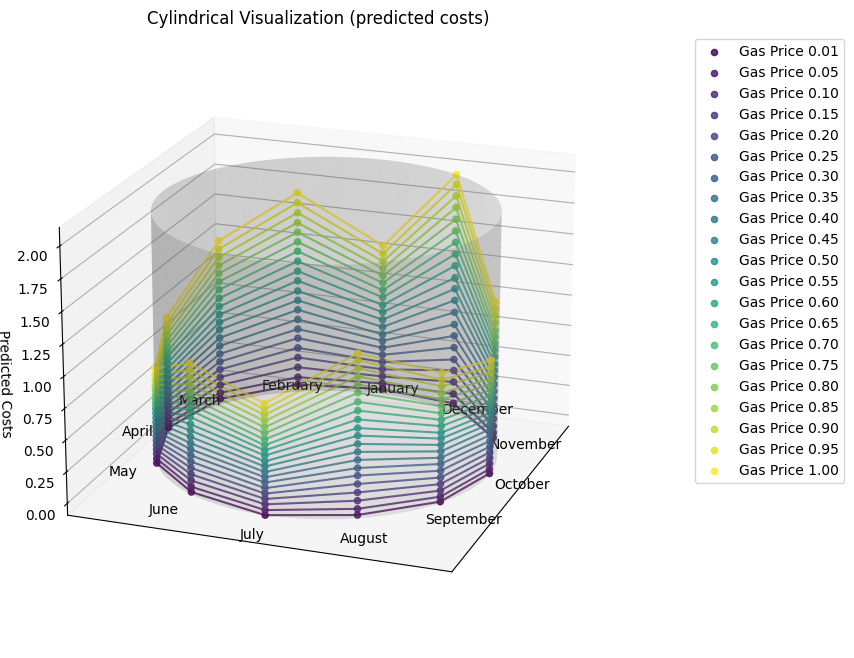

In [32]:
file_path = "/kaggle/input/cilinder-data/GP0tot1voorCilinder.xlsx"
cilinder_data = pd.read_excel(file_path)
scaler_Xc = StandardScaler()
scaler_yc = StandardScaler()
Xc = cilinder_data.iloc[:,2:5].values
Xc = scaler_Xc.fit_transform(Xc)

def cilinder(model):
    # X_test3_unscaled etc. aanmaken
    Xc_unscaled = scaler_Xc.inverse_transform(Xc)
    month_cos = Xc_unscaled[:, 1]
    month_sin = Xc_unscaled[:, 0]
    gas_prices = Xc_unscaled[:, 2]
    predicted_costs = scaler_y.inverse_transform(model.predict(Xc))
    unique_gas_prices = np.unique(gas_prices)
    gas_price_colors = plt.cm.viridis(np.linspace(0, 1, len(unique_gas_prices)))
    months = np.linspace(0, 2 * np.pi, 12, endpoint=False)
    month_labels = [
        'January', 'February', 'March', 'April', 'May', 'June', 
        'July', 'August', 'September', 'October', 'November', 'December'
    ]

    # Helperfunctie voor het plotten
    def plot_costs(ax, costs, title, color, linestyle, marker):
        for idx, gas_price in enumerate(unique_gas_prices):
            # Filter points for this gas price
            indices = np.where(gas_prices == gas_price)[0]
            x = month_cos[indices]
            y = month_sin[indices]
            z = costs[indices]
            
            # Sort the points by month to ensure continuity
            
            sorted_indices = np.argsort(np.arctan2(y, x))  # Sort by angle (month order)
            x = x[sorted_indices]
            y = y[sorted_indices]
            z = z[sorted_indices]
            x_closed = np.append(x, x[0])
            y_closed = np.append(y, y[0])
            z_closed = np.append(z, z[0])
            
            local_color = gas_price_colors[idx]
    
            # Plot the points and lines
            ax.scatter(x, y, z, color=local_color, marker=marker, 
                       label=f'Gas Price {gas_price:.2f}', alpha=0.8)
            ax.plot(x_closed, y_closed, z_closed, linestyle=linestyle, color=local_color, alpha=0.8)

        # Semi-transparent cylinder
        theta_cylinder = np.linspace(0, 2 * np.pi, 100)
        z_cylinder = np.linspace(min(costs), max(costs), 50)
        theta_cylinder, z_cylinder = np.meshgrid(theta_cylinder, z_cylinder)
        x_cylinder = np.cos(theta_cylinder)
        y_cylinder = np.sin(theta_cylinder)
        ax.plot_surface(x_cylinder, y_cylinder, z_cylinder, 
                        alpha=0.2, color='gray', edgecolor='none')

        # Add month labels to the circle
        for i, month_label in enumerate(month_labels):
            x_label = 1.2 * np.cos(months[i])  # Slightly outward for visibility
            y_label = 1.2 * np.sin(months[i])
            ax.text(x_label, y_label, 0, month_label, ha='center', va='center', fontsize=10)

        # Hide axis ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_zlabel('Predicted Costs')
        ax.set_title(title)
        
        # Set viewing angle
        ax.view_init(elev=20, azim=200)
        
        # Place legend outside the plot
        ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

    # Maak de figuur en plot
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(111, projection='3d')
    plot_costs(ax1, predicted_costs, 
               'Cylindrical Visualization (predicted costs)',
               color='blue', linestyle='solid', marker='o')
    plt.savefig('cilinder_show.png', format = 'png', dpi = 300)
    plt.show()
cilinder(best_model3)